In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
#os.chdir("..")

In [ ]:
print(f"Notebook running in {os.getcwd()}")

In [6]:
import json
import os
import numpy as np
import torch
import h5py
import pandas as pd
import tifffile
from matplotlib import pyplot as plt
from loguru import logger

from survos2 import survos
from survos2.entity.entities import make_entity_bvol, make_bounding_vols, make_entity_df
from survos2.entity.anno.pseudo import make_pseudomasks, make_anno, generate_annotation_volume
from survos2.entity.sampler import (centroid_to_bvol, crop_pts_bb, sample_bvol, viz_bvols) 
from survos2.frontend.main import init_ws, roi_ws
from survos2.frontend.nb_utils import view_volume, view_dataset
from survos2.frontend.nb_utils import slice_plot
from survos2.frontend.nb_utils import view_vols_points, view_vols_labels, view_volumes, view_volume
from survos2.entity.components import filter_proposal_mask, filter_small_components
from survos2.entity.instance.det import init_entity_workflow
from survos2.frontend.nb_utils import add_feature, add_anno
from survos2.entity.entities import get_entities_df
from survos2.server.pipeline import view_dataset
from survos2.entity.pipeline_ops import make_masks

from monai.metrics import DiceHelper
plt.rc('image', cmap='gray')

In [7]:
import logging
numba_logger = logging.getLogger('numba')
numba_logger.setLevel(logging.WARNING)
import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR)


# Load data from workspace

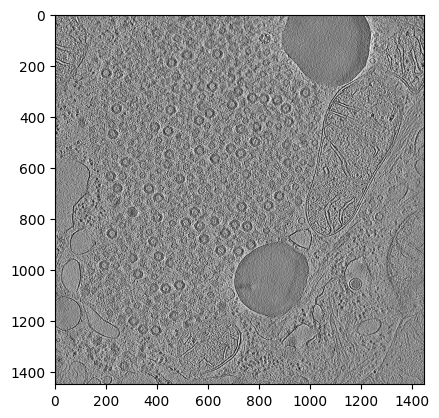

In [10]:
%matplotlib inline
from survos2.frontend.nb_utils import view_dataset

main_vol = tifffile.imread("datasets/Original_Tomogram_ROI_16_144_450_1900_450_1900.tif")
plt.imshow(main_vol[50,:])

[0 1 2 3 4]


Text(0.5, 1.0, 'BG')

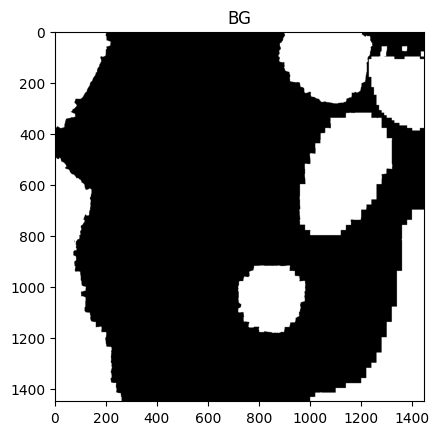

In [13]:
rom survos2.frontend.nb_utils import view_dataset
bg_mask = tifffile.imread("datasets/BackgroundMask_Rough.tif")
# Extracting masks from background mask image and constructing bg_mask.
bg_mask = bg_mask & 15
print(np.unique(bg_mask & 15))
bg_mask_all =  (bg_mask == 2) + (bg_mask == 3) + (bg_mask == 4)
plt.imshow(bg_mask_all[9,:])
plt.title("BG")

In [15]:
from survos2.frontend.nb_utils import view_dataset
gold_anno = tifffile.imread("datasets/Gold_ExpertMask_ROI_16_144_450_1900_450_1900.tif")

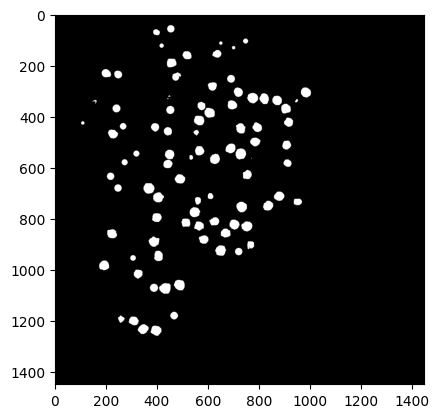

In [16]:
gold_dlp = (gold_anno == 1)
plt.imshow(gold_dlp[50,:])

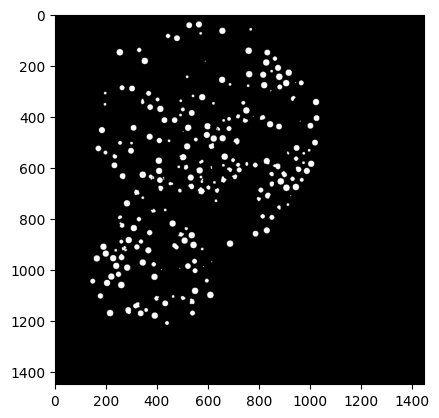

In [17]:
gold_slp = (gold_anno == 5)
plt.imshow(gold_slp[50,:])

# Load data and set ROI

In [18]:
project_file = 'default_project_file.json'
roi_name="main"
padding = (64, 64, 64)


entity_meta_full=   {'0':{'name':'dlp', 'size': (21,21,21), 'core_radius':(8,8,8)},
             '1':{'name':'dlpf','size': (20,20,20), 'core_radius':(12,12,12)},
             '2':{'name':'dlpm','size': (23,23,23), 'core_radius':(14,14,14)},
             '5':{'name':'slp', 'size': (18,18,18), 'core_radius':(8,8,8)}}



# Setup workflow

In [ ]:
crowdsourced_entities = pd.read_csv("crowdsourced_entities.csv")


In [ ]:
from survos2.entity.instance.det import PatchWorkflow
from survos2.entity.anno.pseudo import organize_entities

combined_clustered_pts, classwise_entities = organize_entities(
        main_vol, np.array(crowdsourced_entities)[:,1:5], entity_meta_full, plot_all=True, flipxy=False)
wparams = {}
wparams["entities_offset"] = (0, 0, 0)



In [22]:
wf = PatchWorkflow(
    [main_vol],
    combined_clustered_pts,
    classwise_entities,
    bg_mask_all,
    wparams,
    classwise_entities,
)

# Proposal seg

In [23]:
#bg_mask_all = np.zeros_like(wf.vols[0])
bg_mask_all.shape, wf.vols[0].shape
wf.bg_mask.shape

(128, 1450, 1450)

In [24]:
%matplotlib inline

wf.params['outdir']= "."
wf.params['workflow_name']= 'wf1'
wf.params['proj'] = 'vf'
wf.params['torch_models_fullpath'] = './tmp'

from survos2.entity.instance.proposals import ProposalSegmentor
proposal_seg = ProposalSegmentor(wf, project_file, roi_name, bg_mask_all=bg_mask_all, patch_size=(48,128,128), padding=(48,128,128))

In [ ]:
proposal_seg.generate_annotation_volume(entity_meta_full, 
                            gt_proportion=1.0,
                            padding=(64,64,64), 
                            generate_random_bg_entities=True,
                            num_before_masking=80,
                            stratified_selection=True,
                            acwe=False,
                            class_proportion={0:1.0, 1: 1, 2: 1.0, 5:1.0})

In [ ]:
proposal_seg.setup_combined_anno()

In [ ]:
# add a set of randomly sampled locations in order to sample patches from locations that are not likely to contain a virus as well as those that do
proposal_seg.setup_augmented_points()

In [ ]:
proposal_seg.aug_pts[:,3]

In [45]:
proposal_seg.make_multiclass_training_volumes(num_training_patches=450, num_augs=1)

INFO - Making patches for 450 locations  - survos2.entity.patches:sample_images_and_labels:285


Making 450 bvols
Augmented point locations (450, 4)
Generating 450 patch volumes from image of shape (224, 1706, 1706)
Generated 450 MarkedPatches of shape (450, 48, 128, 128)
Generating 450 patch volumes from image of shape (224, 1706, 1706)
Generated 450 MarkedPatches of shape (450, 48, 128, 128)
Marked patches, unique label vols [0. 1.], img mean: 0.3633714007037778
Num augs1
raw_X_train (1080, 48, 128, 128), raw_X_test (270, 48, 128, 128), raw_y_train(1080, 48, 128, 128), raw_y_test(270, 48, 128, 128)
Augmented image vols shape (1350, 48, 128, 128), label vols shape (1350, 48, 128, 128)
Saving image vols ./vf_may0622_patch_vols1350_img_vols_3101_1454.h5
Saving image vols ./vf_may0622_patch_vols1350_img_labels_3101_1454.h5
Saving image vols ./vf_may0622_patch_vols_1350_mask_gt_3101_1454.h5


INFO - Making patches for 450 locations  - survos2.entity.patches:sample_images_and_labels:285


Making 450 bvols
Augmented point locations (450, 4)
Generating 450 patch volumes from image of shape (224, 1706, 1706)
Generated 450 MarkedPatches of shape (450, 48, 128, 128)
Generating 450 patch volumes from image of shape (224, 1706, 1706)
Generated 450 MarkedPatches of shape (450, 48, 128, 128)
Marked patches, unique label vols [0. 1.], img mean: 0.34297745207291613
Num augs1
raw_X_train (1080, 48, 128, 128), raw_X_test (270, 48, 128, 128), raw_y_train(1080, 48, 128, 128), raw_y_test(270, 48, 128, 128)
Augmented image vols shape (1350, 48, 128, 128), label vols shape (1350, 48, 128, 128)
Saving image vols ./vf_may0622_patch_vols1350_img_vols_3101_1455.h5
Saving image vols ./vf_may0622_patch_vols1350_img_labels_3101_1455.h5
Saving image vols ./vf_may0622_patch_vols_1350_mask_gt_3101_1455.h5


INFO - Making patches for 450 locations  - survos2.entity.patches:sample_images_and_labels:285


Making 450 bvols
Augmented point locations (450, 4)
Generating 450 patch volumes from image of shape (224, 1706, 1706)
Generated 450 MarkedPatches of shape (450, 48, 128, 128)
Generating 450 patch volumes from image of shape (224, 1706, 1706)
Generated 450 MarkedPatches of shape (450, 48, 128, 128)
Marked patches, unique label vols [0. 1.], img mean: 0.4259313332408153
Num augs1
raw_X_train (1080, 48, 128, 128), raw_X_test (270, 48, 128, 128), raw_y_train(1080, 48, 128, 128), raw_y_test(270, 48, 128, 128)
Augmented image vols shape (1350, 48, 128, 128), label vols shape (1350, 48, 128, 128)
Saving image vols ./vf_may0622_patch_vols1350_img_vols_3101_1457.h5
Saving image vols ./vf_may0622_patch_vols1350_img_labels_3101_1457.h5
Saving image vols ./vf_may0622_patch_vols_1350_mask_gt_3101_1457.h5


In [1]:
import monai

In [ ]:
proposal_seg.train_multiple_class_model(num_epochs=10, model_type="attention_unet")

In [50]:
from survos2.api.objects import load_entities

In [61]:
#from survos2.entity.train import train_seg
from survos2.entity.pipeline_ops import make_proposal
proposal = make_proposal(wf.vols[0],
                         './tmp/attention_unet_fullblob3101_1646.pt',
                         'attention_unet',
                        patch_size=(128,256,256), 
                         patch_overlap=(96,192,192),
                         overlap_mode='average'
                        )

Predicting segmentation on volume of shape (128, 1450, 1450)
AttentionUnet(
  (model): Sequential(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): ReLU()
          )
        )
        (1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): ReLU()
          )
        )
      )
    )
    (1): AttentionLayer(
      (attention): AttentionBlock(
        (W_g): Sequential(
          (0): Convolution(
            (conv): Conv3d(16, 8, kernel_size=(1, 1, 1), stride=(

100%|█████████████████████████████████████████| 400/400 [01:43<00:00,  3.85it/s]


Aggregated volume of torch.Size([1, 128, 1450, 1450])


In [48]:
proposal.shape

torch.Size([1, 128, 1450, 1450])

Plotting at location: 40, 400, 300


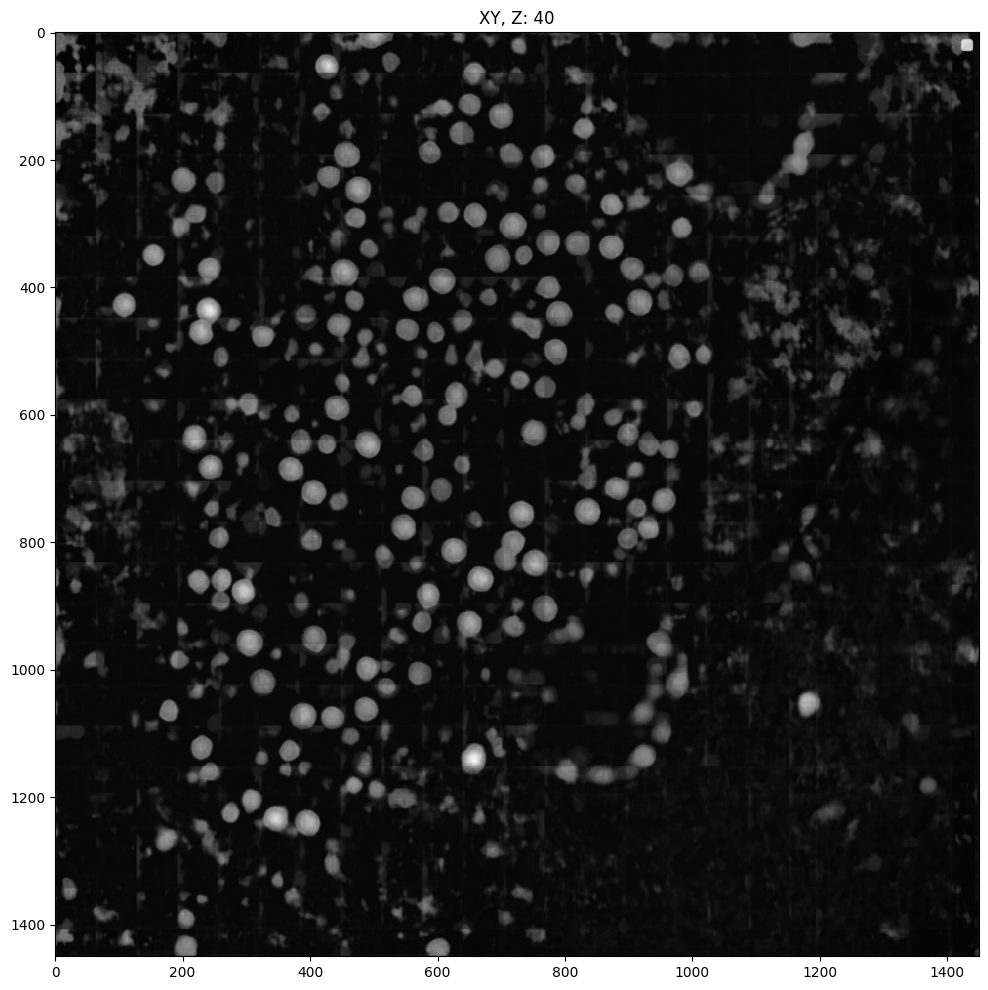

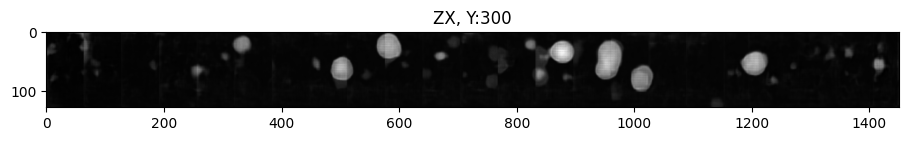

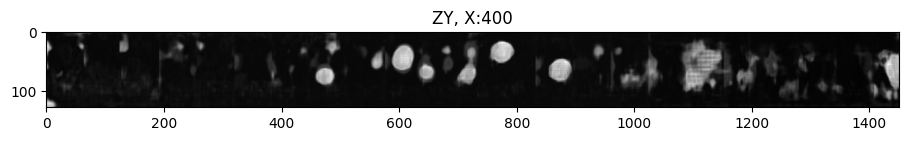

In [62]:
slice_plot(proposal[0,:], slice_idxs=(40,400,300))

In [44]:


tifffile.imsave('attention_unet_dlp.tif',np.array(proposal))